## Confidentiality

This notebook is downloaded from Quantopian and is for demonstrational purposes only.

Please do not copy or distribute this notebook.

## Previous knowledge

Please read the following resources for a deep understanding of this notebook.

*1 https://www.quantopian.com/docs/user-guide/overview#user-guide-overview*

## Introduction

In this notebook, Quantopian is introduced, the problems it aims to solve, and the tools it provides to solve problems. 

## Quantopian research

Typically, researching cross-sectional equity factors involves the following steps:
1. Defining a universe of assets.
2. Defining a factor over the universe.
3. Testing the factor.
4. Sharing, discussing and enhancing results with other quants 

### Research Environment

The code in this tutorial can best be run in Quantopian's **Research** environment. Research is a hosted [Jupyter](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html) notebook environment that allows to interactively run Python code. Research comes with a mix of proprietary and open-source Python libraries pre-installed. 

### Step 1 - Defining a universe of assets.

The first step in researching a cross-sectional equity factor is selecting a “universe” of equities over which the factor will be defined. In this context, a universe represents the set of equities that will be considered, when performing computations later. On Quantopian, defining a universe is done using the [**the Pipeline API**](https://www.quantopian.com/docs/user-guide/tools/pipeline). Later on, The same API is used to compute factors over the equities in this universe.

The Pipeline API provides a uniform interface to several [built-in datasets](https://www.quantopian.com/docs/data-reference/overview), as well as any [custom datasets](https://www.quantopian.com/custom-datasets) that are uploaded to an account. Pipeline makes it easy to define computations or expressions using built-in and custom data. For example, the following code snippet imports two built-in datasets, [FactSet Fundamentals](https://www.quantopian.com/docs/data-reference/factset_fundamentals) and [FactSet Equity Metadata](https://www.quantopian.com/docs/data-reference/equity_metadata), and uses them to define an equity universe.

In [ ]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data.factset import Fundamentals, EquityMetadata

is_share = EquityMetadata.security_type.latest.eq('SHARE')
is_primary = EquityMetadata.is_primary.latest
primary_shares = (is_share & is_primary)
market_cap = Fundamentals.mkt_val.latest

universe = market_cap.top(1000, mask=primary_shares)

The above example defines a universe to be the top 1000 primary issue common stocks ranked by market cap. Universes can be defined using any of the data available on Quantopian. Additionally, private data can be uploaded, such as index constituents or another custom universe to the platform using the Self-Serve Data tool. To learn more about uploading a custom dataset, see the [Self-Serve Data documentation](https://www.quantopian.com/docs/user-guide/tools/self-serve). For now, let's stick with the universe definition above.

### Step 2 - Defining a factor.

After defining a universe, the next step is to define a factor for testing. On Quantopian, a factor is a computation that produces numerical values at a regular frequency for all assets in a universe. Similar to step 1, the [**the Pipeline API**](https://www.quantopian.com/docs/user-guide/tools/pipeline) is used to define factors. In addition to providing a fast, uniform API on top of pre-integrated and custom datasets, Pipeline also provides a set of built-in [classes](https://www.quantopian.com/docs/api-reference/pipeline-api-reference#built-in-factors) and [methods](https://www.quantopian.com/docs/api-reference/pipeline-api-reference#methods-that-create-factors) that can be used to quickly define factors. For example, the following code snippet defines a momentum factor using fast and slow moving average computations.

In [ ]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import EquityPricing
from quantopian.pipeline.factors import SimpleMovingAverage

# 1-month (21 trading day) moving average factor.
fast_ma = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=21)

# 6-month (126 trading day) moving average factor.
slow_ma = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=126)

# Divide fast_ma by slow_ma to get momentum factor and z-score.
momentum = fast_ma / slow_ma
momentum_factor = momentum.zscore()

Now a universe and a factor is defined, you can choose a market and time period and simulate the factor. One of the defining features of the Pipeline API is that it allows to define universes and factors using high level terms, without having to worry about common data engineering problems like [adjustments](https://www.quantopian.com/docs/data-reference/overview#corporate-action-adjustments), [point-in-time data](https://www.quantopian.com/docs/data-reference/overview#point-in-time-data), [symbol mapping](https://www.quantopian.com/docs/data-reference/overview#asset-identifiers), delistings, and data alignment. Pipeline does all of that work behind the scenes and allows to focus your time on building and testing factors.

The below code creates a Pipeline instance that adds the factor as a column and screens down to equities in the universe. The Pipline is then run over the US equities market from 2016 to 2019. 

In [ ]:
from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import EquityPricing
from quantopian.pipeline.data.factset import Fundamentals, EquityMetadata
from quantopian.pipeline.domain import US_EQUITIES, ES_EQUITIES
from quantopian.pipeline.factors import SimpleMovingAverage

is_share = EquityMetadata.security_type.latest.eq('SHARE')
is_primary = EquityMetadata.is_primary.latest
primary_shares = (is_share & is_primary)
market_cap = Fundamentals.mkt_val.latest

universe = market_cap.top(1000, mask=primary_shares)

# 1-month moving average factor.
fast_ma = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=21)

# 6-month moving average factor.
slow_ma = SimpleMovingAverage(inputs=[EquityPricing.close], window_length=126)

# Divide fast_ma by slow_ma to get momentum factor and z-score.
momentum = fast_ma / slow_ma
momentum_factor = momentum.zscore()


# Create a US equities pipeline with our momentum factor, screening down to our universe.
pipe = Pipeline(
    columns={
        'momentum_factor': momentum_factor,
    },
    screen=momentum_factor.percentile_between(50, 100, mask=universe),
    domain=US_EQUITIES,
)

# Run the pipeline from 2016 to 2019 and display the first few rows of output.
from quantopian.research import run_pipeline
factor_data = run_pipeline(pipe, '2016-01-01', '2019-01-01')
print("Result contains {} rows of output.".format(len(factor_data)))
factor_data.head()

Result contains 376888 rows of output.


momentum_factor
2016-01-04 00:00:00+00:00 Equity(67 [ADSK])          1.211285
                          Equity(76 [TAP])           1.252603
                          Equity(114 [ADBE])         0.816407
                          Equity(161 [AEP])          0.407097
                          Equity(185 [AFL])          0.288024

In [ ]:
Running the above code produces a pandas dataframe, stored in the variable `factor_data`, and displays the first few rows of its output. The dataframe contains a momentum factor value per equity per day, for each equity in the universe, based on the definition that's provided. Now that there is a momentum value for each equity in the universe, and each day between 2016 and 2019, you can test to see if the factor is predictive.

**Note:** Due to licensing restrictions, some datasets on Quantopian have [holdouts](https://www.quantopian.com/docs/data-reference/overview#holdout-periods) on the most recent year or two of data. Each dataset is documented with the length of holdout on recent data. For instance, FactSet Fundamentals has the most recent year of data held out. Holdouts to not apply to [Quantopian Enterprise](https://factset.quantopian.com).


### Step 3 - Test the factor.

The next step is testing the predictiveness of the factor that's defined in step 2. In order to determine if the factor is predictive, the forward returns for the factor's assets over the factor's dates are calculated. The factor and the forward returns are then passed into [**Alphalens**](https://www.quantopian.com/docs/user-guide/tools/alphalens). The following code cell generates the returns data and sends it to Alphalens.

In [ ]:
from quantopian.research import get_forward_returns
import alphalens as al

# Get the 1-day forward returns for the assets and dates in the factor
returns_df = get_forward_returns(
    factor_data['momentum_factor'],
    [1],
    US_EQUITIES
)

# Format the factor and returns data so that we can run it through Alphalens.
al_data = al.utils.get_clean_factor(
    factor_data['momentum_factor'],
    returns_df,
    quantiles=5,
    bins=None,
)

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


Then, you can create a factor tearsheet to analyze the momentum factor. 

Quantiles Statistics


,min,max,mean,std,count,count %
factor_quantile,,,,,,
1,-0.074957,0.421041,0.210711,0.087592,75500,20.047477
2,0.036035,0.565006,0.345345,0.088620,75319,19.999416
3,0.176784,0.749338,0.493422,0.095196,74975,19.908074
4,0.334028,1.049384,0.694447,0.117171,75319,19.999416
5,0.550052,8.979528,1.237802,0.522630,75493,20.045618


Returns Analysis


,1D
Ann. alpha,-0.010
beta,0.113
Mean Period Wise Return Top Quantile (bps),0.194
Mean Period Wise Return Bottom Quantile (bps),-0.434
Mean Period Wise Spread (bps),0.628


/venvs/py35/lib/python3.5/site-packages/alphalens/tears.py:275: UserWarning: 'freq' not set in factor_data index: assuming business day
  UserWarning,


<Figure size 1008x576 with 0 Axes>

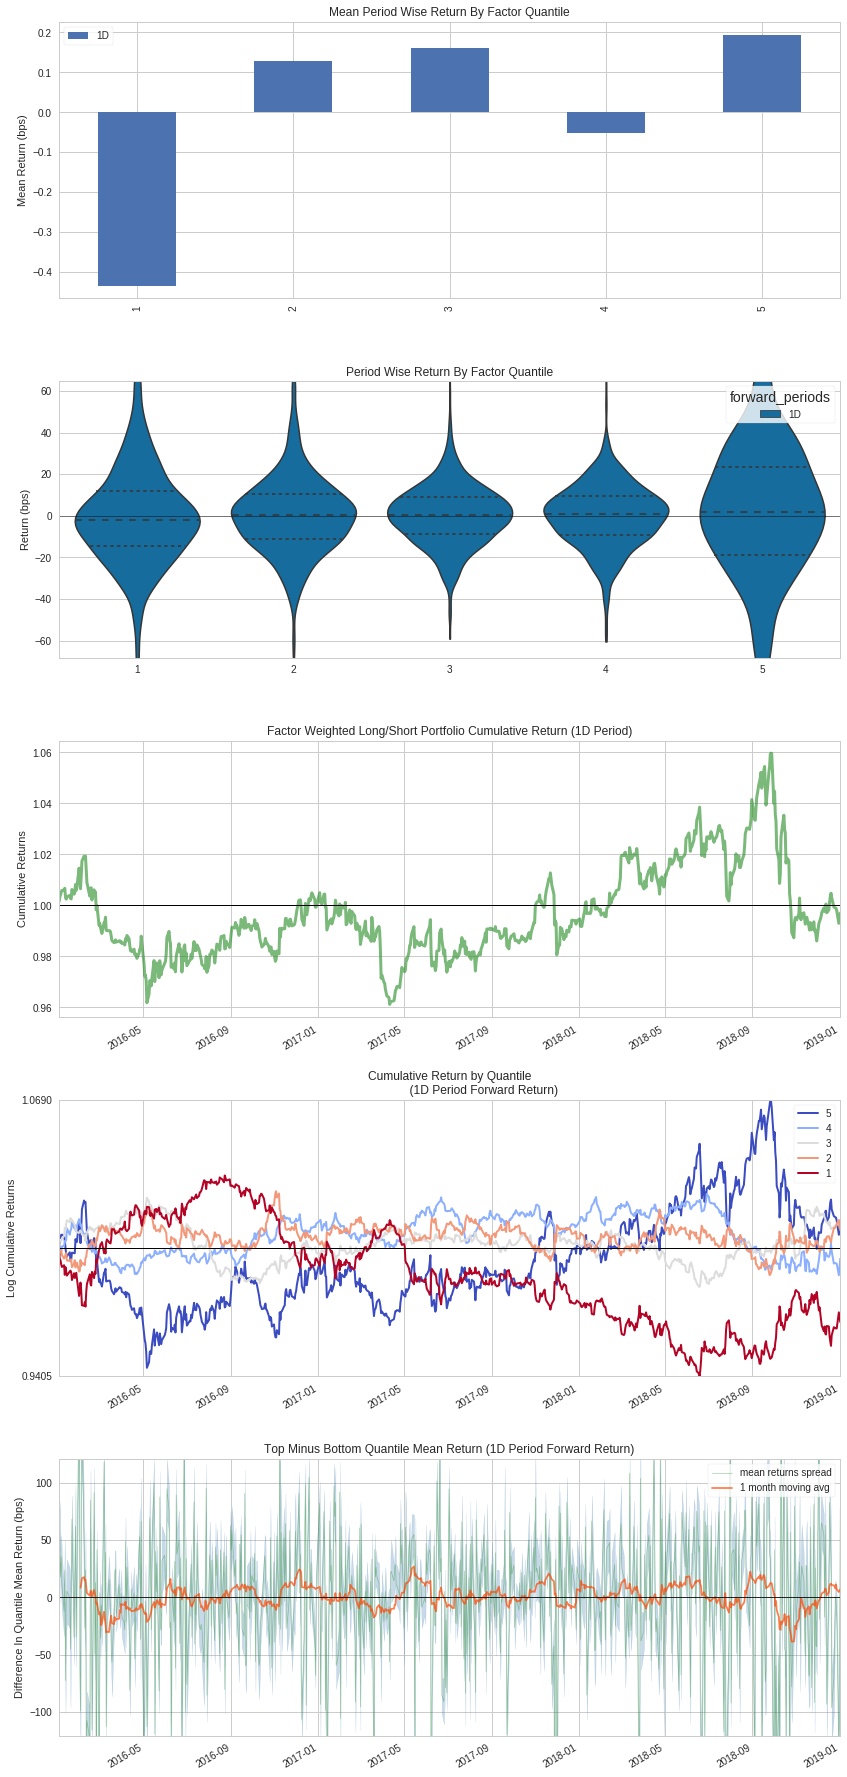

Information Analysis


,1D
IC Mean,0.005
IC Std.,0.135
Risk-Adjusted IC,0.038
t-stat(IC),1.035
p-value(IC),0.301
IC Skew,-0.288
IC Kurtosis,0.007


/venvs/py35/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6521: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  alternative="'density'", removal="3.1")
/venvs/py35/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


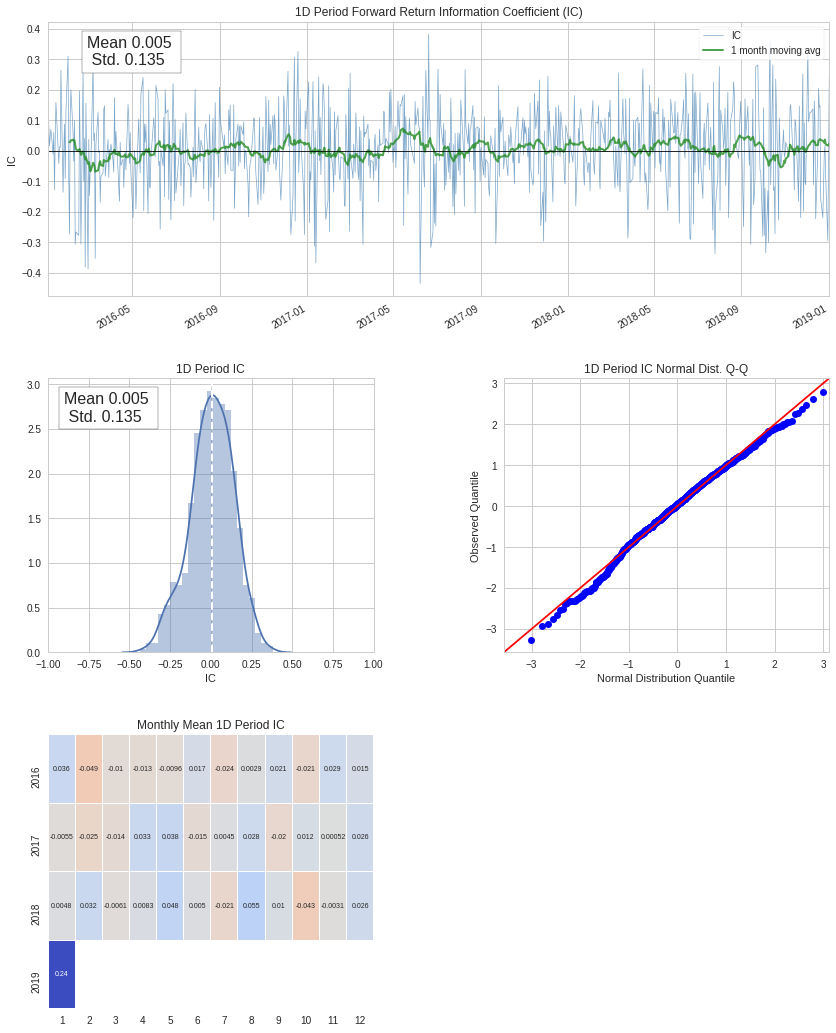

/venvs/py35/lib/python3.5/site-packages/alphalens/utils.py:912: UserWarning: Skipping return periods that aren't exact multiples of days.
  + " of days."


Turnover Analysis


,1D
Quantile 1 Mean Turnover,0.117
Quantile 2 Mean Turnover,0.111
Quantile 3 Mean Turnover,0.096
Quantile 4 Mean Turnover,0.070
Quantile 5 Mean Turnover,0.030


,1D
Mean Factor Rank Autocorrelation,0.996


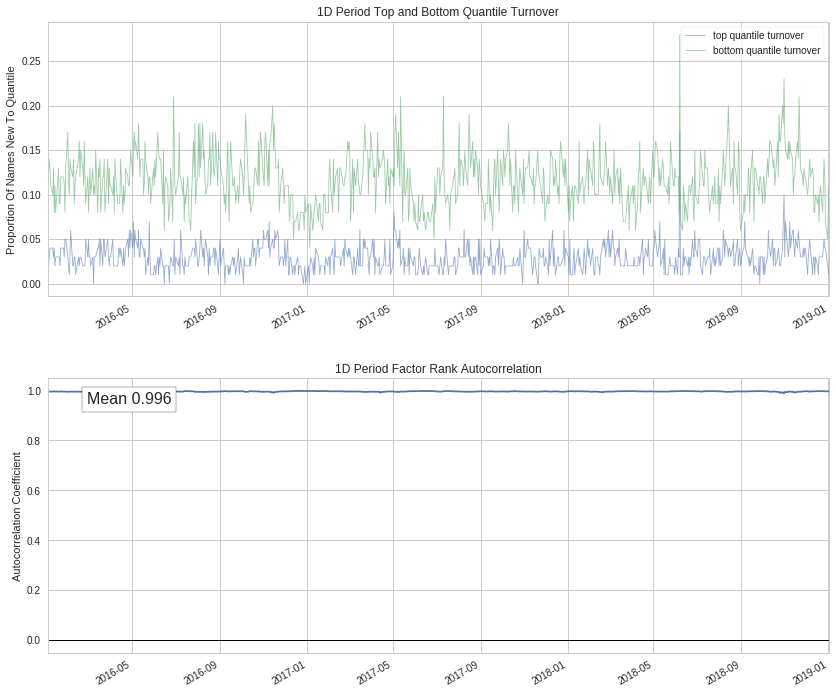

In [ ]:
from alphalens.tears import create_full_tear_sheet

create_full_tear_sheet(al_data)

The Alphalens tearsheet offers insight into the predictive ability of a factor. 



